In [1]:
#*******************
# PYTHON VER: 3.5.2
#*******************
# libraries
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip

In [2]:
# paths
input_camera_calibration_path = "./../camera_calibration/"
output_camera_calibration_path = "./../camera_calibration_output/"
input_test_images_path = "./../test_images/"
output_test_images_path = "./../test_images_output/"
input_test_videos_path = "./../test_videos/"
output_test_videos_path = "./../test_videos_output/"

In [3]:
# function for perspective transform
def perspective_transform(undist_img):
	# taking height and width of undistorted image
	h, w = undist_img.shape[:2]
	# coordinates of trapezium on source and destination image
	src = np.float32([(575, 464), (707, 464), (258, 682), (1049, 682)])
	dest = np.float32([(450, 0), (w - 450, 0), (450, h), (w - 450, h)])
	# perspective transform step
	M = cv2.getPerspectiveTransform(src, dest)
	M_inverse = cv2.getPerspectiveTransform(dest, src)
	warped = cv2.warpPerspective(undist_img, M, (w, h), flags=cv2.INTER_LINEAR)
	return warped, M, M_inverse

In [4]:
# function for HLS color model
def hls(img, min_thresh=220, max_thresh=255):
	# converting img into hls_img
	hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
	# taking l-channel
	l_img = hls_img[:, :, 1]
	l_img = l_img * (255 / np.max(l_img))
	# applying threshold
	bin_img = np.zeros_like(l_img)
	bin_img[(l_img > min_thresh) & (l_img <= max_thresh)] = 1
	return bin_img

In [5]:
# function for Lab color space
def lab(img, min_thresh=190, max_thresh=255):
	# converting image into lab color model
	lab_img = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
	# taking last channel
	b_img = lab_img[:, :, 2]
	# normalize if lane is yellow
	if(np.max(b_img) > 175):
		b_img = b_img * (255 / np.max(b_img))
	# applying threshold
	bin_img = np.zeros_like(b_img)
	bin_img[(b_img > min_thresh) & (b_img <= max_thresh)] = 1
	return bin_img

In [6]:
# define method to fit polynomial to binary image with lines extracted, using sliding window
def sliding_window_polyfit(img):
	# Take a histogram of the bottom half of the image
	histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
	# Find the peak of the left and right halves of the histogram
	# These will be the starting point for the left and right lines
	midpoint = np.int(histogram.shape[0]//2)
	quarter_point = np.int(midpoint//2)
	# Previously the left/right base was the max of the left/right half of the histogram
	# this changes it so that only a quarter of the histogram (directly to the left/right) is considered
	leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
	rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint    
	# Choose the number of sliding windows
	nwindows = 10
	# Set height of windows
	window_height = np.int(img.shape[0]/nwindows)
	# Identify the x and y positions of all nonzero pixels in the image
	nonzero = img.nonzero()
	nonzeroy = np.array(nonzero[0])
	nonzerox = np.array(nonzero[1])
	# Current positions to be updated for each window
	leftx_current = leftx_base
	rightx_current = rightx_base
	# Set the width of the windows +/- margin
	margin = 80
	# Set minimum number of pixels found to recenter window
	minpix = 40
	# Create empty lists to receive left and right lane pixel indices
	left_lane_inds = []
	right_lane_inds = []
	# Rectangle data for visualization
	rectangle_data = []
	# Step through the windows one by one
	for window in range(nwindows):
		# Identify window boundaries in x and y (and right and left)
		win_y_low = img.shape[0] - (window+1)*window_height
		win_y_high = img.shape[0] - window*window_height
		win_xleft_low = leftx_current - margin
		win_xleft_high = leftx_current + margin
		win_xright_low = rightx_current - margin
		win_xright_high = rightx_current + margin
		rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
		# Identify the nonzero pixels in x and y within the window
		good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
		good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
		# Append these indices to the lists
		left_lane_inds.append(good_left_inds)
		right_lane_inds.append(good_right_inds)
		# If you found > minpix pixels, recenter next window on their mean position
		if len(good_left_inds) > minpix:
			leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
		if len(good_right_inds) > minpix:        
			rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
	# Concatenate the arrays of indices
	left_lane_inds = np.concatenate(left_lane_inds)
	right_lane_inds = np.concatenate(right_lane_inds)
	# Extract left and right line pixel positions
	leftx = nonzerox[left_lane_inds]
	lefty = nonzeroy[left_lane_inds] 
	rightx = nonzerox[right_lane_inds]
	righty = nonzeroy[right_lane_inds]
	left_fit, right_fit = (None, None)
	# Fit a second order polynomial to each
	if len(leftx) != 0:
		left_fit = np.polyfit(lefty, leftx, 2)
	if len(rightx) != 0:
		right_fit = np.polyfit(righty, rightx, 2)
	visualization_data = (rectangle_data, histogram)
	return left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data

In [7]:
# Define a class to receive the characteristics of each line detection
class Line():
	def __init__(self):
		# was the line detected in the last iteration?
		self.detected = False  
		# x values of the last n fits of the line
		self.recent_xfitted = [] 
		#average x values of the fitted line over the last n iterations
		self.bestx = None     
		#polynomial coefficients averaged over the last n iterations
		self.best_fit = None  
		#polynomial coefficients for the most recent fit
		self.current_fit = []  
		#radius of curvature of the line in some units
		self.radius_of_curvature = None 
		#distance in meters of vehicle center from the line
		self.line_base_pos = None 
		#difference in fit coefficients between last and new fits
		self.diffs = np.array([0,0,0], dtype='float') 
		#number of detected pixels
		self.px_count = None
	def add_fit(self, fit, inds):
		# add a found fit to the line, up to n
		if fit is not None:
			if self.best_fit is not None:
				# if we have a best fit, see how this new fit compares
				self.diffs = abs(fit-self.best_fit)
			if (self.diffs[0] > 0.001 or \
				self.diffs[1] > 1.0 or \
				self.diffs[2] > 100.) and \
				len(self.current_fit) > 0:
				# bad fit! abort! abort! ... well, unless there are no fits in the current_fit queue, then we'll take it
				self.detected = False
			else:
				self.detected = True
				self.px_count = np.count_nonzero(inds)
				self.current_fit.append(fit)
				if len(self.current_fit) > 5:
					# throw out old fits, keep newest n
					self.current_fit = self.current_fit[len(self.current_fit)-5:]
				self.best_fit = np.average(self.current_fit, axis=0)
		# or remove one from the history, if not found
		else:
			self.detected = False
			if len(self.current_fit) > 0:
				# throw out oldest fit
				self.current_fit = self.current_fit[:len(self.current_fit)-1]
			if len(self.current_fit) > 0:
				# if there are still any fits in the queue, best_fit is their average
				self.best_fit = np.average(self.current_fit, axis=0)

In [8]:
# Define method to fit polynomial to binary image based upon a previous fit (chronologically speaking);
# this assumes that the fit will not change significantly from one video frame to the next
def polyfit_using_prev_fit(binary_warped, left_fit_prev, right_fit_prev):
	nonzero = binary_warped.nonzero()
	nonzeroy = np.array(nonzero[0])
	nonzerox = np.array(nonzero[1])
	margin = 80
	left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin)))
	right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))
	# Again, extract left and right line pixel positions
	leftx = nonzerox[left_lane_inds]
	lefty = nonzeroy[left_lane_inds] 
	rightx = nonzerox[right_lane_inds]
	righty = nonzeroy[right_lane_inds]
	left_fit_new, right_fit_new = (None, None)
	if len(leftx) != 0:
		# Fit a second order polynomial to each
		left_fit_new = np.polyfit(lefty, leftx, 2)
	if len(rightx) != 0:
		right_fit_new = np.polyfit(righty, rightx, 2)
	return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds

In [9]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
	new_img = np.copy(original_img)
	if l_fit is None or r_fit is None:
		return original_img
	# Create an image to draw the lines on
	warp_zero = np.zeros_like(binary_img).astype(np.uint8)
	color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
	h,w = binary_img.shape
	ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
	left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
	right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]
	# Recast the x and y points into usable format for cv2.fillPoly()
	pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
	pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
	pts = np.hstack((pts_left, pts_right))
	# Draw the lane onto the warped blank image
	cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
	cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
	cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)
	# Warp the blank back to original image space using inverse perspective matrix (Minv)
	newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
	# Combine the result with the original image
	result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
	return result

In [10]:
def draw_data(original_img, curv_rad, center_dist):
	new_img = np.copy(original_img)
	h = new_img.shape[0]
	font = cv2.FONT_HERSHEY_DUPLEX
	text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
	cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
	direction = ''
	if center_dist > 0:
		direction = 'right'
	elif center_dist < 0:
		direction = 'left'
	abs_center_dist = abs(center_dist)
	text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
	cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
	return new_img

In [11]:
def calc_curv_rad_and_center_dist(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
	# Define conversions in x and y from pixels space to meters
	ym_per_pix = 3.048/100 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
	xm_per_pix = 3.7/378 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
	left_curverad, right_curverad, center_dist = (0, 0, 0)
	# Define y-value where we want radius of curvature
	# I'll choose the maximum y-value, corresponding to the bottom of the image
	h = bin_img.shape[0]
	ploty = np.linspace(0, h-1, h)
	y_eval = np.max(ploty)
	# Identify the x and y positions of all nonzero pixels in the image
	nonzero = bin_img.nonzero()
	nonzeroy = np.array(nonzero[0])
	nonzerox = np.array(nonzero[1])
	# Again, extract left and right line pixel positions
	leftx = nonzerox[l_lane_inds]
	lefty = nonzeroy[l_lane_inds] 
	rightx = nonzerox[r_lane_inds]
	righty = nonzeroy[r_lane_inds]
	if len(leftx) != 0 and len(rightx) != 0:
		# Fit new polynomials to x,y in world space
		left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
		right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
		# Calculate the new radii of curvature
		left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
		right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
		# Now our radius of curvature is in meters
	# Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
	if r_fit is not None and l_fit is not None:
		car_position = bin_img.shape[1]/2
		l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
		r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
		lane_center_position = (r_fit_x_int + l_fit_x_int) /2
		center_dist = (car_position - lane_center_position) * xm_per_pix
	return left_curverad, right_curverad, center_dist

In [12]:
# main function
def pipeline(img):
	global mtx, dist
	# undistorting image
	undist_img = cv2.undistort(img, mtx, dist, None, mtx)
	# perspective transforming image
	perspect_img, M, M_inverse = perspective_transform(undist_img)
	# getting HLS and Lab images
	hls_img = hls(perspect_img)
	lab_img = lab(perspect_img)
	# combining hls and lab images
	combine = np.zeros_like(lab_img)
	combine[(hls_img == 1) | (lab_img == 1)] = 1
	# if both left and right lines were detected last frame, use polyfit_using_prev_fit, otherwise use sliding window
	if not l_line.detected or not r_line.detected:
		l_fit, r_fit, l_lane_inds, r_lane_inds, _ = sliding_window_polyfit(combine)
	else:
		l_fit, r_fit, l_lane_inds, r_lane_inds = polyfit_using_prev_fit(combine, l_line.best_fit, r_line.best_fit)
	# invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
	if l_fit is not None and r_fit is not None:
		# calculate x-intercept (bottom of image, x=image_height) for fits
		h = img.shape[0]
		l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
		r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
		x_int_diff = abs(r_fit_x_int-l_fit_x_int)
		if abs(350 - x_int_diff) > 100:
			l_fit = None
			r_fit = None
	l_line.add_fit(l_fit, l_lane_inds)
	r_line.add_fit(r_fit, r_lane_inds)
	# draw the current best fit if it exists
	if l_line.best_fit is not None and r_line.best_fit is not None:
		img_out = draw_lane(undist_img, combine, l_line.best_fit, r_line.best_fit, M_inverse)
		rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(combine, l_line.best_fit, r_line.best_fit, l_lane_inds, r_lane_inds)
		img_out = draw_data(img_out, (rad_l+rad_r)/2, d_center)
	else:
		img_out = undist_img
	return img_out

In [13]:
# number of inside corners in chessboard images
nx = 9
ny = 6

In [14]:
# getting all chessboard image names
chessboard_imagenames = os.listdir(input_camera_calibration_path)

In [15]:
# for storing object points (3D image) and image points (2D image) of all images
object_points = []
image_points = []

In [16]:
# reading all images and locating their inside corners
for i in range(len(chessboard_imagenames)):
	# for storing object points of i-th image
	object_p = np.zeros((nx * ny, 3), np.float32)
	object_p[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
	# path of i-th image
	imagename = input_camera_calibration_path + chessboard_imagenames[i]
	# reading image
	img = cv2.imread(imagename)
	# converting image into a grayscale image
	gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	# finding inside corners in gray_img
	status, corners = cv2.findChessboardCorners(gray_img, (nx, ny), None)
	# if status is True then display image
	if(status == True):
		# storing image points and object points
		image_points.append(corners)
		object_points.append(object_p)
	else:
		print("cv2 failed to find inside corners in chessboard images: " + chessboard_imagenames[i])

cv2 failed to find inside corners in chessboard images: calibration4.jpg
cv2 failed to find inside corners in chessboard images: calibration1.jpg
cv2 failed to find inside corners in chessboard images: calibration5.jpg


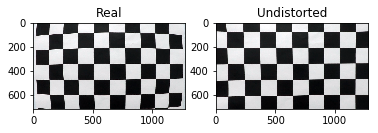

True

In [17]:
# testing undistortion on a chessboard image
img = cv2.imread(input_camera_calibration_path + "calibration1.jpg")
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, img.shape[:2], None, None)
undist_img = cv2.undistort(img, mtx, dist, None, mtx)
# showing image before and after undistortion
fig = plt.figure()
a = fig.add_subplot(1, 2, 1)
plt.imshow(img)
a.set_title("Real")
a = fig.add_subplot(1, 2, 2)
plt.imshow(undist_img)
a.set_title("Undistorted")
plt.show()
# saving undistorted image
cv2.imwrite(output_camera_calibration_path + "output_calibration1.jpg", undist_img)

In [18]:
l_line = Line()
r_line = Line()

In [19]:
# getting list of test images
files = os.listdir(input_test_images_path)
# reading each image and undistorting it
for i in range(len(files)):
	# path of i-th image
	file_path = input_test_images_path + files[i]
	# reading image
	img = cv2.imread(file_path)
	# transforming color model
	img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
	# passing image to pipeline function
	img_out = pipeline(img)
	# converting color space of output image
	img_out = cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB)
	# saving output image
	cv2.imwrite(output_test_images_path + "output_" + files[i], img_out)

In [20]:
# getting list of test videos
files = os.listdir(input_test_videos_path)
# marking lanes in each video
for i in range(len(files)):
	# making video of project video
	video_input1 = VideoFileClip(input_test_videos_path + files[i])
	processed_video = video_input1.fl_image(pipeline)
	processed_video.write_videofile(output_test_videos_path + "output_" + files[i], audio=False)

[MoviePy] >>>> Building video ./../test_videos_output/output_project_video.mp4
[MoviePy] Writing video ./../test_videos_output/output_project_video.mp4


100%|█████████▉| 1260/1261 [03:25<00:00,  6.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./../test_videos_output/output_project_video.mp4 

[MoviePy] >>>> Building video ./../test_videos_output/output_challenge_video.mp4
[MoviePy] Writing video ./../test_videos_output/output_challenge_video.mp4


100%|██████████| 485/485 [01:13<00:00,  6.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./../test_videos_output/output_challenge_video.mp4 

